<a href="https://colab.research.google.com/github/esmolkina/-/blob/main/ABCXYZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Есть данные о продажах препаратов в аптеке - дата продажи, количество, закупочная, розничная цена.
Нужно сделать АВС анализ по трем параметрам - кво проданных единниц, выручка, прибыль и сопоставить эти категории с вариативностью продаж по XYZ анализу для выработки стратегии продвижения
Границы классов АВС делаю зависящими от прараметров, а не 80 и 95% - для оптимального распределения номенклатуры по классам

Идея по консолидации классов АВС многомерного анализа из статьи https://habr.com/ru/articles/811991/

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
upper_level = 0.95
middle_level = 0.8

In [ ]:
df = pd.read_excel('ABCXYZ.xlsx',usecols = ('DR_Dat', 'DR_NDrugs','DR_Kol', 'DR_CZak','DR_CRoz'))

df.head(2)

,DR_Dat,DR_NDrugs,DR_Kol,DR_CZak,DR_CRoz
0,2022-08-01,ГАСТАЛ №12 ТАБ. Д/РАСС.,1.0,196.71,270.0
1,2022-08-01,"ТОБРОПТ 0,3% 5МЛ. №1 ГЛ.КАПЛИ ФЛ./КАП. /РОМФАРМ/",1.0,106.21,127.0


In [ ]:
#считаю суммарные продажи для всех наименований, для АВС анализа по трем параметрам
df_abc = df.groupby('DR_NDrugs').agg({'DR_Kol':'sum',
                                      'DR_CZak':'sum',
                                      'DR_CRoz':'sum'}).reset_index()
#считаю прибыль как долю наценки в розничной цене
df_abc['profit'] = round((df_abc['DR_CRoz'] - df_abc['DR_CZak'])/df_abc['DR_CZak'],2)
df_abc.head(2)

,DR_NDrugs,DR_Kol,DR_CZak,DR_CRoz,profit
0,"911-ВЕНОЛГОН ГЕЛЬ Д/НОГ ПРИ ТЯЖЕСТИ,БОЛИ,ОТЕКА...",1.0,75.81,120.0,0.58
1,911-ГЕЛЬ-БАЛЬЗАМ Д/НОГ КОНСКИЙ КАШТАН 100МЛ. ТУБА,1.0,66.40,105.0,0.58


In [ ]:
#многомерный авс анализ по столбцам columns
def abc(df, columns):

    for col in columns:

        df[f'rel_{col}'] = df[col] / df[col].sum() #доля строки в общей сумме столбца

        df = df.sort_values(f'rel_{col}',ascending = False) #сортировка по убыванию доли строки в общей сумме

        df[f'cumsum_{col}'] = df[f'rel_{col}'].cumsum() #сумма доли строки накопительным итогом

        df[f'abc_{col}'] = np.where(df[f'cumsum_{col}'] < middle_level, 'A',
                                    np.where(df[f'cumsum_{col}'] < upper_level, 'B', 'C')) #присвоение категорий АВС


    return df

In [ ]:
#функция рисует распределение классов column с учетом наполненности номенклатурами
def graph_class(df, column):

    df['count'] = df.groupby(column)['DR_NDrugs'].transform('count') #наполненность класса номенклатурами
    df = df.sort_values(by = 'count', ascending = False)

    names = list(df[column]) #список классов

    plt.figure(figsize=(10,4))

    plt.hist(df[column], color = '#56B4E9', edgecolor = 'black',
             bins = int(180/5), label=names)

    plt.xticks(rotation=90)

    plt.title('Распределение классов ')
    plt.xlabel('Классы')
    plt.ylabel('Наполненность класса')

    plt.show();


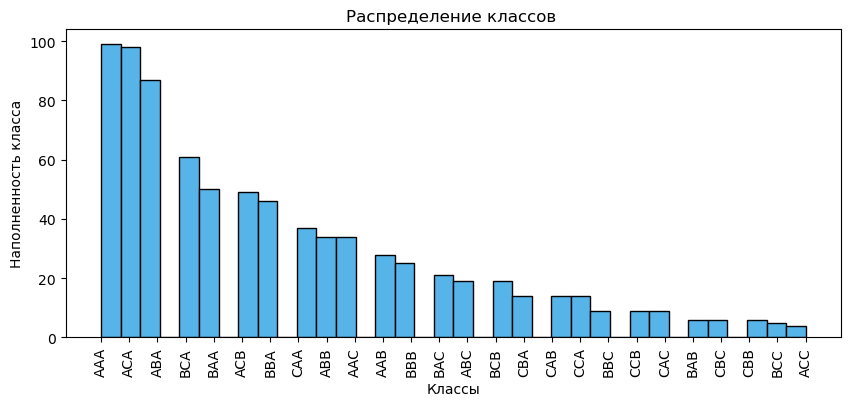

In [ ]:
#применяю функцию многомерного АВС анализа по количеству продаж, товарообороту, прибыли
df_abc = abc(df_abc, ['DR_Kol', 'DR_CRoz', 'profit']).sort_values(by = 'profit', ascending = False)

#композиция классов по трем параметрам
df_abc['ABC'] = df_abc['abc_DR_Kol'] + df_abc['abc_DR_CRoz'] + df_abc['abc_profit']

#распределение классификации ABC всех наименований
graph_class(df_abc, 'ABC')

In [ ]:
#функция определяет сводную категорию в зависимости от сочетания классов
#А - основной товар
#B - вспомогательный товар для наполнения ассортиментной матрицы
#С - товар под заказ покупателя
#Out - товар выводится из ассортимента

def category(arg):
    categories = {
        "AAA": 'A', "AAB": 'A', "ABA": 'A', "ABB": 'A',
        "ACA": 'A', "BAA": 'A', "BBA": 'A',
        "AAC": 'B', "ABC": 'B', "ACB": 'B', "ACC": 'B',
        "BAB": 'B', "BAC": 'B', "BBB": 'B', "BBC": 'B',
        "BCA": 'B', "CAA": 'B', "CAB": 'B', "CBA": 'B',
        "BCB": 'C', "BCC": 'C', "CAC": 'C',
        "CBB": 'C', "CBC": 'C'
    }
    return categories.get(arg, 'Out')

df_abc['ABC_union'] = df_abc['ABC'].apply(category)

In [ ]:
print('Количество классов в объединенной АВС классификации: ', df_abc['ABC_union'].nunique())

Количество классов в объединенной АВС классификации:  4


In [ ]:
#считаю вариативность количества продаж по датам для всех наименований, для XYZ анализа
df_xyz = df.groupby('DR_NDrugs').agg(avg_col = ('DR_Kol','mean'),
                                    std_col = ('DR_Kol','std')).reset_index().fillna(0)


df_xyz['var']  =  round(df_xyz['std_col']/df_xyz['avg_col'],2)

#смотрю как раcпределена вариантивность
#больше всего строк с нулевой вариативностью, тк данные за неполный месяц и продажи единичные
#в этом случае стандартное отклонение не посчитано и обнулено
df_xyz['var'].value_counts(normalize = True)

0.00    0.956413
0.47    0.012453
0.71    0.002491
0.28    0.002491
0.35    0.002491
1.38    0.001245
0.62    0.001245
1.36    0.001245
0.43    0.001245
0.20    0.001245
1.14    0.001245
0.79    0.001245
0.24    0.001245
0.38    0.001245
0.69    0.001245
1.07    0.001245
0.58    0.001245
0.76    0.001245
0.61    0.001245
0.89    0.001245
0.64    0.001245
0.49    0.001245
1.16    0.001245
0.25    0.001245
Name: var, dtype: float64

In [ ]:
#функция классификации XYZ - границы делаю исходя из распределения вариативности проданного количества
def xyz(df, column):

     df['XYZ'] = np.where(df[column] == 0.0, 'X',
                    np.where(df[column] < 0.47, 'Y', 'Z'))

     return df

In [ ]:
df_xyz = xyz(df_xyz,'var')
df_xyz['XYZ'].value_counts(normalize = True)

X    0.956413
Z    0.032379
Y    0.011208
Name: XYZ, dtype: float64

Объединяю маркировки классов АВС и XYZ

In [ ]:
df_res = df_abc[['DR_NDrugs','DR_Kol','DR_CZak','DR_CRoz','profit','ABC_union']].merge(df_xyz[['DR_NDrugs','XYZ']], on = ['DR_NDrugs'])

df_res['ABCXYZ'] = df_res['ABC_union'] + df_res['XYZ']

df_res.head(3)

,DR_NDrugs,DR_Kol,DR_CZak,DR_CRoz,profit,ABC_union,XYZ,ABCXYZ
0,"ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 2,5Х7,2 №1 /ВЕРОФАРМ/",68.0,16.64,32.0,0.92,A,Z,AZ
1,КОНТЕЙНЕР Д/СБОРА БИОМАТЕРИАЛА 120МЛ. УНИВЕРС....,2.0,15.76,28.0,0.78,A,X,AX
2,АСКОРБИНОВАЯ К-ТА 25МГ. ЯБЛОКО №10 ТАБ. КРУТКА...,3.0,20.58,36.0,0.75,A,X,AX


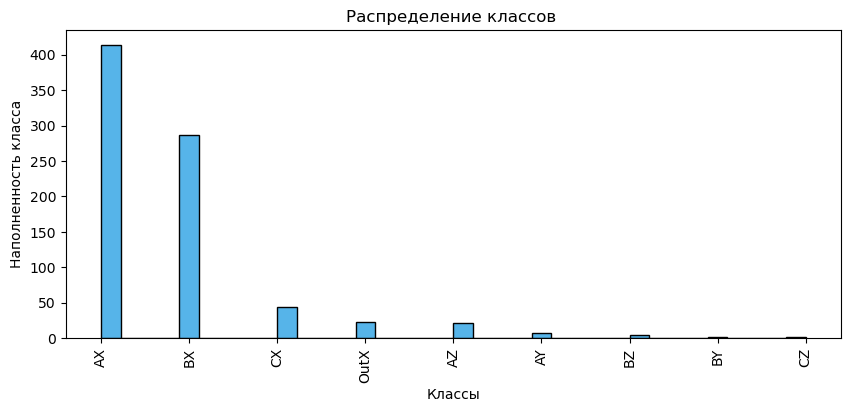

In [ ]:
#итоговое распределение классов АВСXYZ анализа
graph_class(df_res, 'ABCXYZ')

In [ ]:
print('Количество классов в ABCXYZ классификации:', df_res['ABCXYZ'].nunique())

Количество классов в ABCXYZ классификации: 9


Присоединяю описания классов и методов работы с ними к готовому списку номенклатуры

In [ ]:
directory = pd.read_excel('Справочник.xlsx')

#список колонок, которые мне нужны для выгрузки результата
columns = ['DR_NDrugs','DR_Kol','DR_CZak','DR_CRoz','profit', 'ABCXYZ']

df_res = df_res[columns].merge(directory, on = 'ABCXYZ')
df_res.head()

,DR_NDrugs,DR_Kol,DR_CZak,DR_CRoz,profit,ABCXYZ,Описание класса,Рекомендации для класса
0,"ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 2,5Х7,2 №1 /ВЕРОФАРМ/",68.0,16.64,32.0,0.92,AZ,"Высокий ранг, спонтанный спрос, трудно прогноз...","Закупки под заказ, без страхового запаса, длин..."
1,ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 6X10 №1 /ВЕРОФАРМ/,13.0,9.24,16.0,0.73,AZ,"Высокий ранг, спонтанный спрос, трудно прогноз...","Закупки под заказ, без страхового запаса, длин..."
2,КОНТЕЙНЕР Д/СБОРА БИОМАТЕРИАЛА 60МЛ. +ШПАТЕЛЬ ...,3.0,13.92,24.0,0.72,AZ,"Высокий ранг, спонтанный спрос, трудно прогноз...","Закупки под заказ, без страхового запаса, длин..."
3,ЛЕЙКОПЛАСТЫРЬ БАКТЕР. 4Х10 №1 /ВЕРОФАРМ/,14.0,10.54,18.0,0.71,AZ,"Высокий ранг, спонтанный спрос, трудно прогноз...","Закупки под заказ, без страхового запаса, длин..."
4,ПЕРЕКИСЬ ВОДОРОДА 3% 100МЛ. №1 Р-Р ДЕЗ.СР-ВО Ф...,13.0,70.14,119.0,0.70,AZ,"Высокий ранг, спонтанный спрос, трудно прогноз...","Закупки под заказ, без страхового запаса, длин..."


In [ ]:
df_res.to_csv("ABCXYZ_result.csv", index=False, sep=";")